# Preprocessing Notebook for the Instant Time Approach

In [20]:
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from collections import defaultdict
import json

In [21]:
import pandas as pd
import os
from tqdm import tqdm

def aggregate_csv(file_list, savepath, min_rows=200, normalize_labels=True):
    """
    Aggregates multiple CSV files into a single CSV file.
    - Each CSV must have the same structure, with the last column being the label.
    - Interpolates missing values in features.
    - Ensures each experiment name is unique.
    - Only includes files with at least `min_rows` rows.
    - Normalizes labels by replacing spaces with underscores (optional).
    """
    aggregated_rows = []
    colnames = None
    used_exp_names = set()

    for file in tqdm(file_list, desc="Aggregating CSVs"):
        try:
            df = pd.read_csv(file, sep=';')
        except Exception as e:
            print(f"Error reading {file}: {e}")
            continue

        if len(df) < min_rows:
            continue

        # Interpolate features (exclude last column)
        df.iloc[:, :-1] = df.iloc[:, :-1].interpolate(method='linear', limit_direction='both')

        if df.iloc[:, :-1].isnull().values.any():
            print(f"Warning: {file} still contains NaNs after interpolation")
            continue

        features = df.iloc[:, :-1].values
        label_raw = df.iloc[0, -1]

        # Normalize label
        if normalize_labels:
            label = str(label_raw).strip().replace(" ", "_").upper()
        else:
            label = str(label_raw).strip()

        # Unique experiment name
        base_exp_name = os.path.splitext(os.path.basename(file))[0]
        exp_name = base_exp_name
        while exp_name in used_exp_names:
            exp_name += "_"
        used_exp_names.add(exp_name)

        for row in features:
            aggregated_rows.append(list(row) + [label, exp_name])

        if colnames is None:
            feature_names = df.columns[:-1]
            colnames = list(feature_names) + ["label", "exp_name"]

    # Create and save aggregated DataFrame
    df_agg = pd.DataFrame(aggregated_rows, columns=colnames)
    df_agg.to_csv(savepath, index=False)
    print(f"✅ Aggregated CSV saved to {savepath} (only experiments with ≥ {min_rows} rows)")



In [22]:
"""
Take the original dataset and aggregate all the CSV files into a single CSV file.
This is done for both the training and test sets.
"""

SCA_dset_dir = "../dataset/SCA"
N = 100 # Number of time steps in each window

train_csvs = []
test_csvs = []

for split in ['TRAINING', 'TEST']:
    split_dir = os.path.join(SCA_dset_dir, split, "NORMALIZED")
    
    for label in os.listdir(split_dir):
        label_dir = os.path.join(split_dir, label)
        
        
        if os.path.isdir(label_dir):
            for filename in os.listdir(label_dir):
                if filename.endswith('.csv'):
                    file_path = os.path.join(label_dir, filename)
                    if split == 'TRAINING':
                        train_csvs.append(file_path)
                    else:
                        test_csvs.append(file_path)




aggregate_csv(file_list=train_csvs, savepath="original_training_set.csv")
#aggregate_csv(file_list=test_csvs, savepath=os.path.join("original_test_set.csv"))

Aggregating CSVs: 100%|██████████| 738/738 [00:04<00:00, 178.61it/s]


✅ Aggregated CSV saved to original_training_set.csv (only experiments with ≥ 200 rows)


(476807, 18)
unique exp_names:  430
unique labels:  21
labels:  ['ACETIC_ACID' 'ACETONE' 'AIR' 'AMMONIA' 'AMMONIUM_CHLORIDE'
 'APPLE_VINEGAR' 'BIOETHANOL' 'CALCIUM_NITRATE' 'DIESEL' 'ETHANOL'
 'FORMIC_ACID' 'GASOLINE' 'HYDROGENE_PEROXIDE' 'HYDROGEN_PEROXIDE'
 'ISOPROPANOL' 'KEROSENE' 'NAPHTA' 'METHANE' 'NITROMETHANE' 'UREA'
 'WATER_VAPOR']


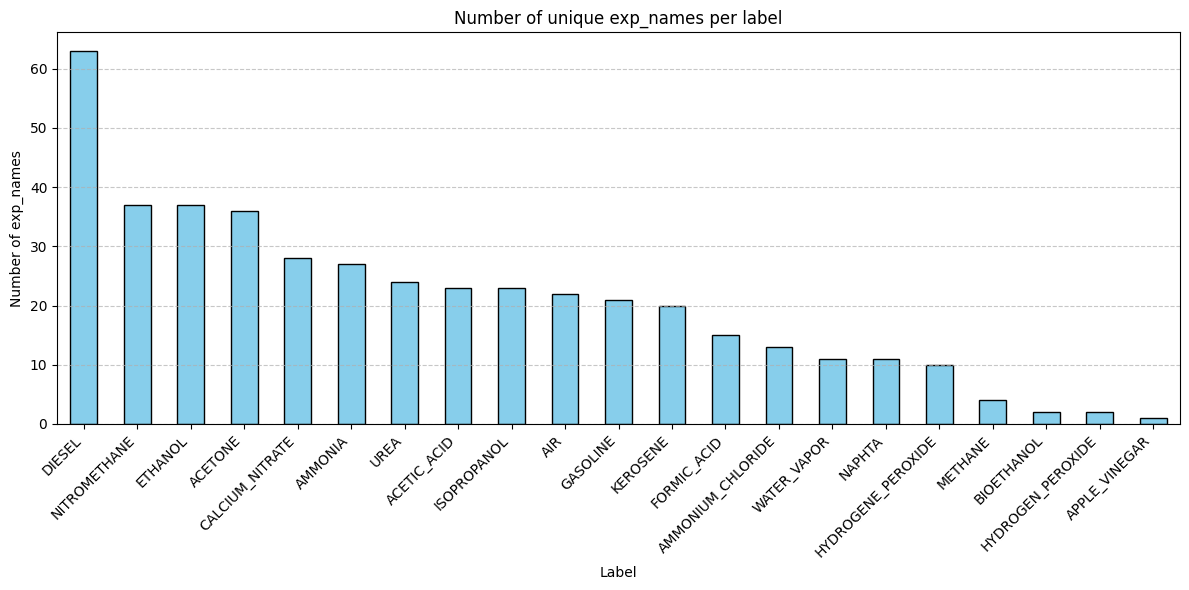

In [23]:
df = pd.read_csv("original_training_set.csv")
print(df.shape)

print("unique exp_names: ", df["exp_name"].nunique())
print("unique labels: ", df["label"].nunique())
print("labels: ", df["label"].unique())

# Get the label for each unique exp_name
exp_labels = df.groupby("exp_name")["label"].first()

# Count how many exp_names each label has
label_counts = exp_labels.value_counts().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
label_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Number of unique exp_names per label")
plt.xlabel("Label")
plt.ylabel("Number of exp_names")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [26]:
# Load the original dataset
df = pd.read_csv("original_training_set.csv")

# Get unique exp_names and their labels
exp_labels = df.groupby("exp_name")["label"].first()

# Prepare split dict
split_dict = defaultdict(list)

# Step 1: Filter out labels with fewer than 10 exp_names
label_counts = exp_labels.value_counts()

# Select valid labels (at least 10 exp_names)
valid_labels = label_counts[label_counts >= 10].index

# Keep only rows with valid labels
df_filtered = df[df["exp_name"].isin(exp_labels[exp_labels.isin(valid_labels)].index)]

# Save the filtered dataset (optional)
df_filtered.to_csv("original_training_set_filtered.csv", index=False)

# Step 2: Stratified split by label
for label in valid_labels:
    exps = exp_labels[exp_labels == label].index.tolist()
    np.random.shuffle(exps)

    n_total = len(exps)
    n_val = max(2, int(0.1 * n_total))
    n_test = max(2, int(0.1 * n_total))

    val_exps = exps[:n_val]
    test_exps = exps[n_val:n_val + n_test]
    train_exps = exps[n_val + n_test:]

    split_dict["val"].extend(val_exps)
    split_dict["test"].extend(test_exps)
    split_dict["train"].extend(train_exps)

# Step 3: Create split DataFrames
df_train = df_filtered[df_filtered["exp_name"].isin(split_dict["train"])]
df_val = df_filtered[df_filtered["exp_name"].isin(split_dict["val"])]
df_test = df_filtered[df_filtered["exp_name"].isin(split_dict["test"])]

# Save split DataFrames
Path("splits").mkdir(parents=True, exist_ok=True)
df_train.to_csv("splits/train.csv", index=False)
df_val.to_csv("splits/val.csv", index=False)
df_test.to_csv("splits/test.csv", index=False)

# Step 4: Save the split dict to JSON
with open("splits/split_dict.json", "w") as f:
    json.dump(split_dict, f, indent=2)

# Output summary
print(f"Train set: {len(split_dict['train'])} exp_names")
print(f"Val set: {len(split_dict['val'])} exp_names")
print(f"Test set: {len(split_dict['test'])} exp_names")

Train set: 339 exp_names
Val set: 41 exp_names
Test set: 41 exp_names


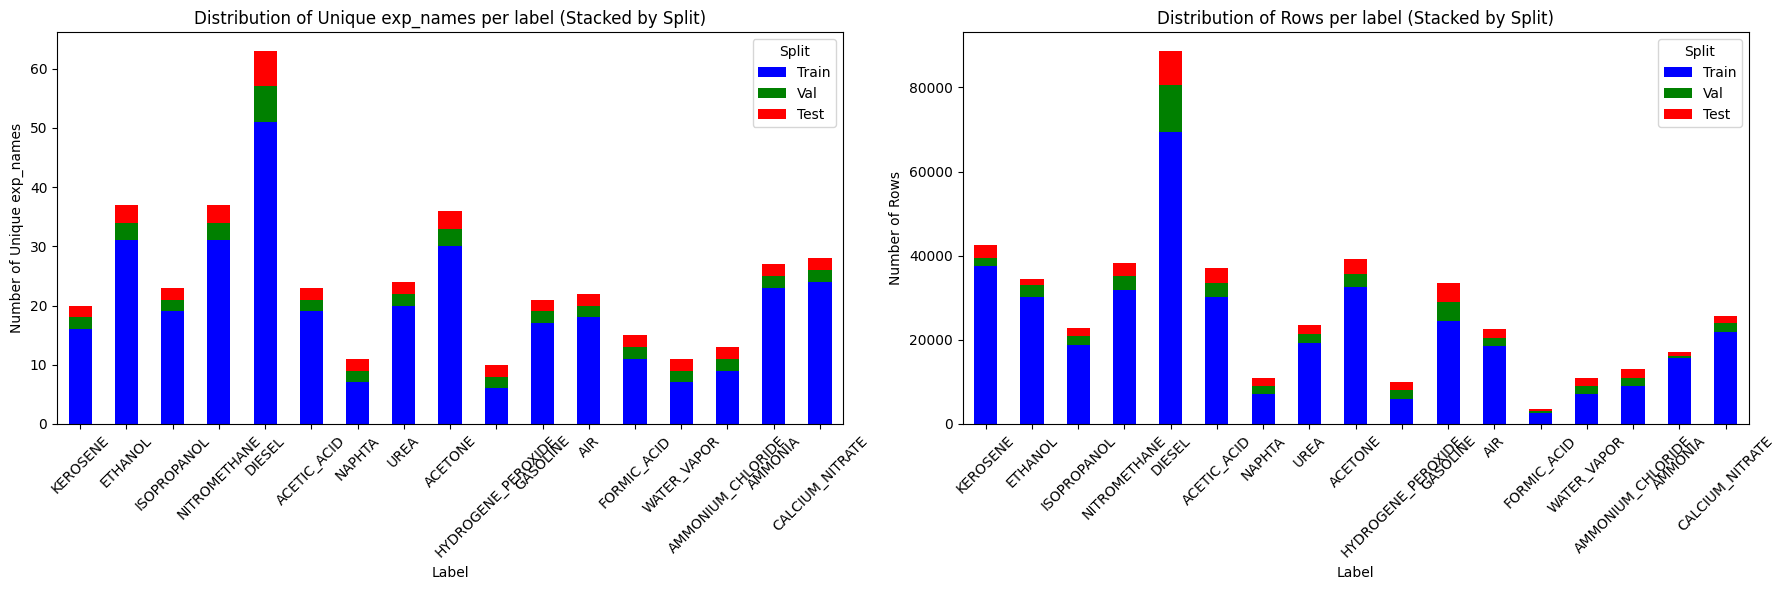

In [29]:
# Load the filtered dataset and splits
df_filtered = pd.read_csv("original_training_set_filtered.csv")
df_train = pd.read_csv("splits/train.csv")
df_val = pd.read_csv("splits/val.csv")
df_test = pd.read_csv("splits/test.csv")

# Get the exp_names for each split
train_exp_names = df_train["exp_name"]
val_exp_names = df_val["exp_name"]
test_exp_names = df_test["exp_name"]

# Get the label for each exp_name
exp_labels = df_filtered.groupby("exp_name")["label"].first()

# Initialize lists for counts
train_exp_counts = []
val_exp_counts = []
test_exp_counts = []
train_row_counts = []
val_row_counts = []
test_row_counts = []

# For each label, count the exp_names and rows in each split
for label in exp_labels.unique():
    # Find exp_names for this label (unique exp_names for each label)
    label_exp_names = exp_labels[exp_labels == label].index

    # Count how many of these unique exp_names are in each split
    train_exp_counts.append(len(train_exp_names[train_exp_names.isin(label_exp_names)].unique()))
    val_exp_counts.append(len(val_exp_names[val_exp_names.isin(label_exp_names)].unique()))
    test_exp_counts.append(len(test_exp_names[test_exp_names.isin(label_exp_names)].unique()))
    
    # Count how many rows for each label in the splits
    train_row_counts.append(sum(df_train[df_train["exp_name"].isin(label_exp_names)]["label"] == label))
    val_row_counts.append(sum(df_val[df_val["exp_name"].isin(label_exp_names)]["label"] == label))
    test_row_counts.append(sum(df_test[df_test["exp_name"].isin(label_exp_names)]["label"] == label))

# Create a DataFrame for plotting
df_plot = pd.DataFrame({
    "label": exp_labels.unique(),
    "train_exp_names": train_exp_counts,
    "val_exp_names": val_exp_counts,
    "test_exp_names": test_exp_counts,
    "train_rows": train_row_counts,
    "val_rows": val_row_counts,
    "test_rows": test_row_counts
})

# Plot the distributions in two subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot for exp_names distribution (unique exp_names for each label)
df_plot.set_index('label')[['train_exp_names', 'val_exp_names', 'test_exp_names']].plot(kind='bar', stacked=True, ax=axs[0], color=['blue', 'green', 'red'])
axs[0].set_title("Distribution of Unique exp_names per label (Stacked by Split)")
axs[0].set_xlabel("Label")
axs[0].set_ylabel("Number of Unique exp_names")
axs[0].legend(title="Split", labels=["Train", "Val", "Test"])
axs[0].tick_params(axis="x", rotation=45)

# Plot for rows distribution (rows for each label)
df_plot.set_index('label')[['train_rows', 'val_rows', 'test_rows']].plot(kind='bar', stacked=True, ax=axs[1], color=['blue', 'green', 'red'])
axs[1].set_title("Distribution of Rows per label (Stacked by Split)")
axs[1].set_xlabel("Label")
axs[1].set_ylabel("Number of Rows")
axs[1].legend(title="Split", labels=["Train", "Val", "Test"])
axs[1].tick_params(axis="x", rotation=45)

# Show the plots
plt.tight_layout()
plt.show()

In [30]:
df = pd.read_csv("original_training_set.csv")

if df.isnull().values.any():
    print("⚠️ There are NaNs in the DataFrame!")
    print(df.isnull().sum())
else:
    print("✅ No NaNs found in the DataFrame.")

✅ No NaNs found in the DataFrame.
